## Owais Aijaz 7610
## oa07610@st.habib.edu.pk

## CS/CE 457/464 Homework 09

In [5]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore") #optional
plt.style.use('fivethirtyeight') #optional
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor

In [73]:
df = pd.read_csv('karachi-weather-2021-2023.csv', parse_dates=['datetime'])
df.head()

,datetime,temp
0,2021-01-01,15.0
1,2021-01-02,15.4
2,2021-01-03,15.6
3,2021-01-04,16.3
4,2021-01-05,17.1


In [75]:
df.sort_values('datetime')
df.isnull().sum()

datetime    0
temp        0
dtype: int64

In [77]:
df = df.set_index('datetime')

In [79]:
df

,temp
datetime,
2021-01-01,15.0
2021-01-02,15.4
2021-01-03,15.6
2021-01-04,16.3
2021-01-05,17.1
...,...
2023-04-22,29.5
2023-04-23,30.0
2023-04-24,30.4


In [81]:
weekly_df = df['temp'].resample('W').mean()

In [83]:
weekly_df.head()

datetime
2021-01-03    15.333333
2021-01-10    16.028571
2021-01-17    17.085714
2021-01-24    19.457143
2021-01-31    17.800000
Freq: W-SUN, Name: temp, dtype: float64

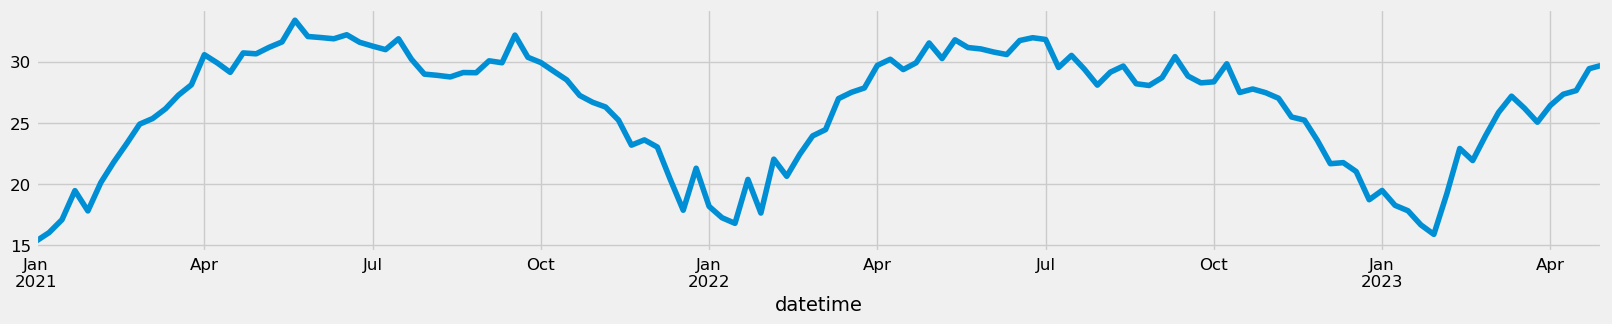

In [12]:
weekly_df.plot(figsize=(18, 3))
plt.show()

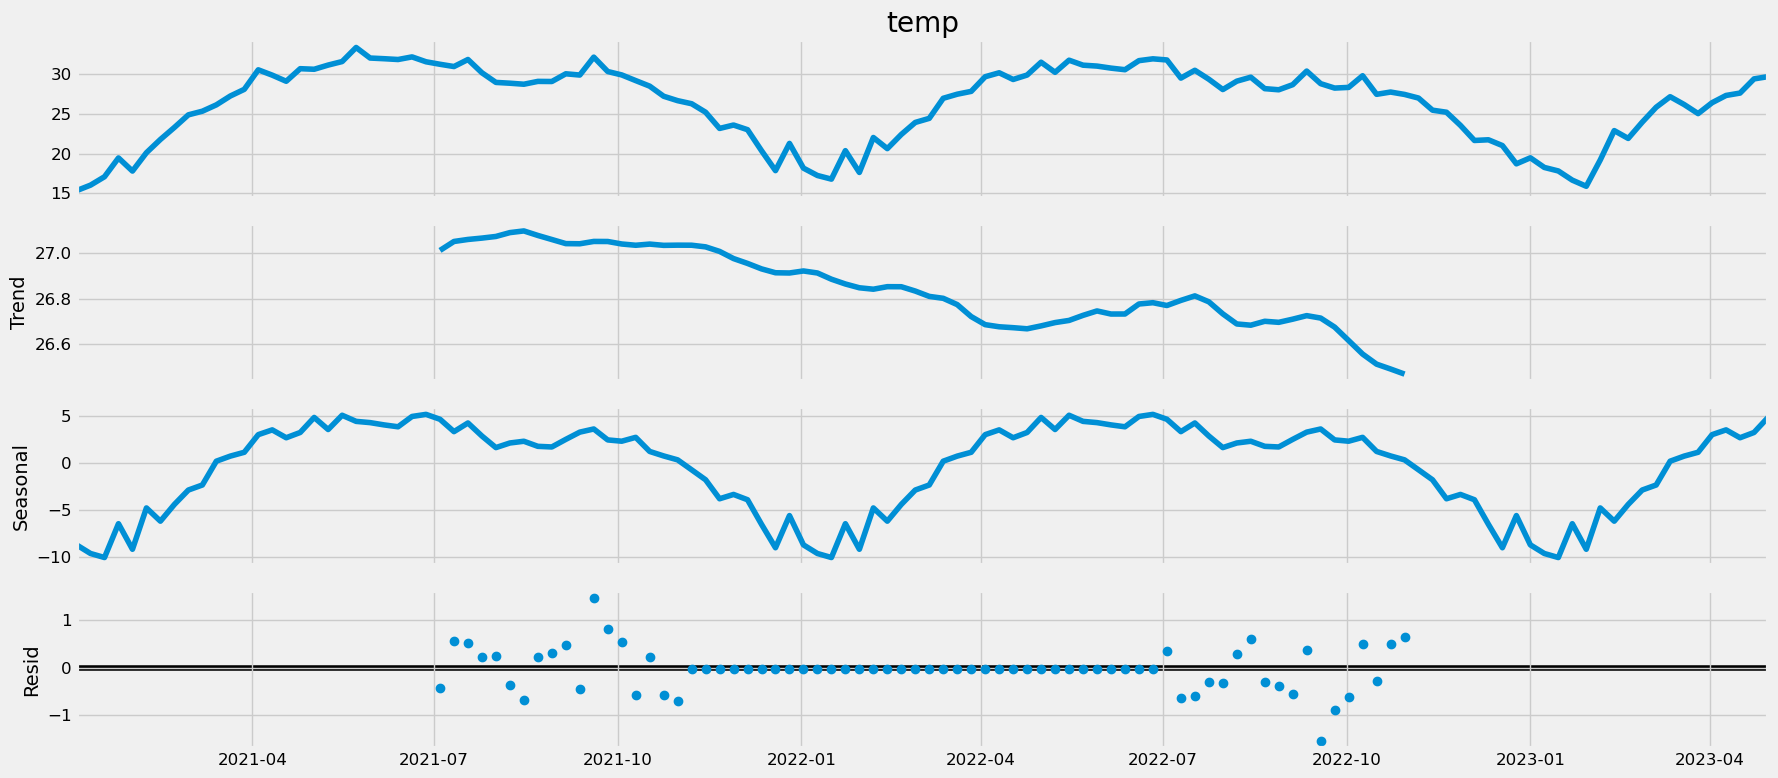

In [13]:
decomposition = sm.tsa.seasonal_decompose(weekly_df, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

#### Observations:

The observed data shows the overall temperature pattern over time. There is a clear cyclical pattern, indicating seasonal temperature variations across the years. Temperatures peak around the mid-year and dip towards the end of the year, which corresponds to Karachi's hot summers and cooler winters.

The trend component highlights the underlying trend in temperature changes over time, excluding seasonal and irregular components. It appears relatively steady, though it slightly fluctuates over time. There is a gentle downward trend mid-period and a recovery towards the end, showing minor long-term changes in temperature.

The seasonal component exhibits a regular repeating pattern, signifying the cyclical temperature changes within each year. This seasonality aligns with Karachi’s typical climate, where temperatures are high in summer and lower in winter.

The residuals capture random fluctuations that are not explained by the trend or seasonality. Most residual values are close to zero, with a few scattered points that could indicate minor anomalies or irregularities.

## Modeling

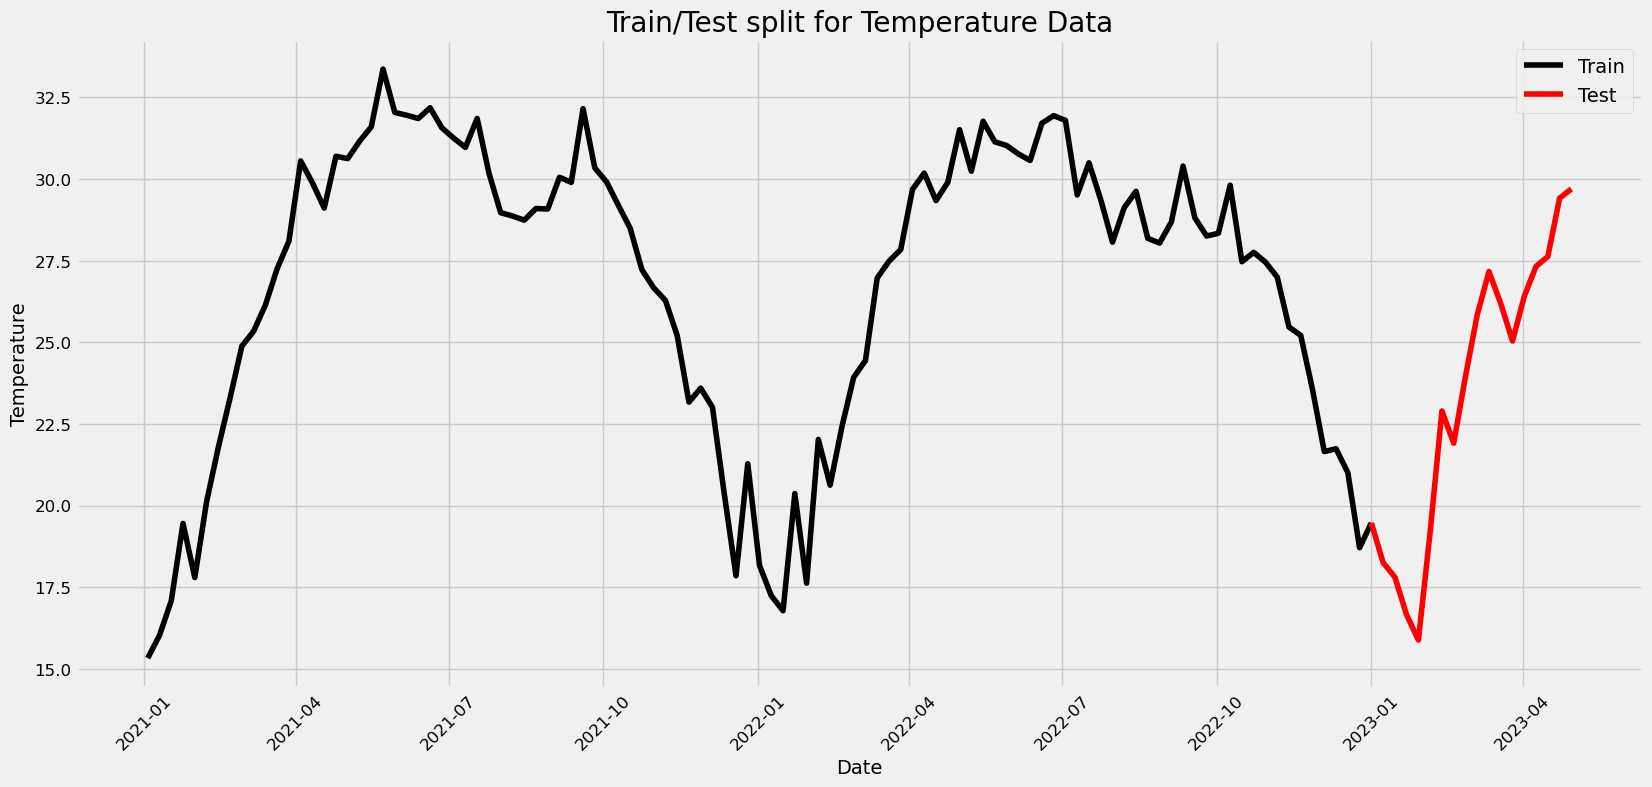

In [16]:
train = weekly_df[weekly_df.index <= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test = weekly_df[weekly_df.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")
plt.legend()
plt.show()

## Using Statistical Models

## ARIMA
ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It assumes that data is stationary with no seasonality

In [19]:
from statsmodels.tsa.arima.model import ARIMA

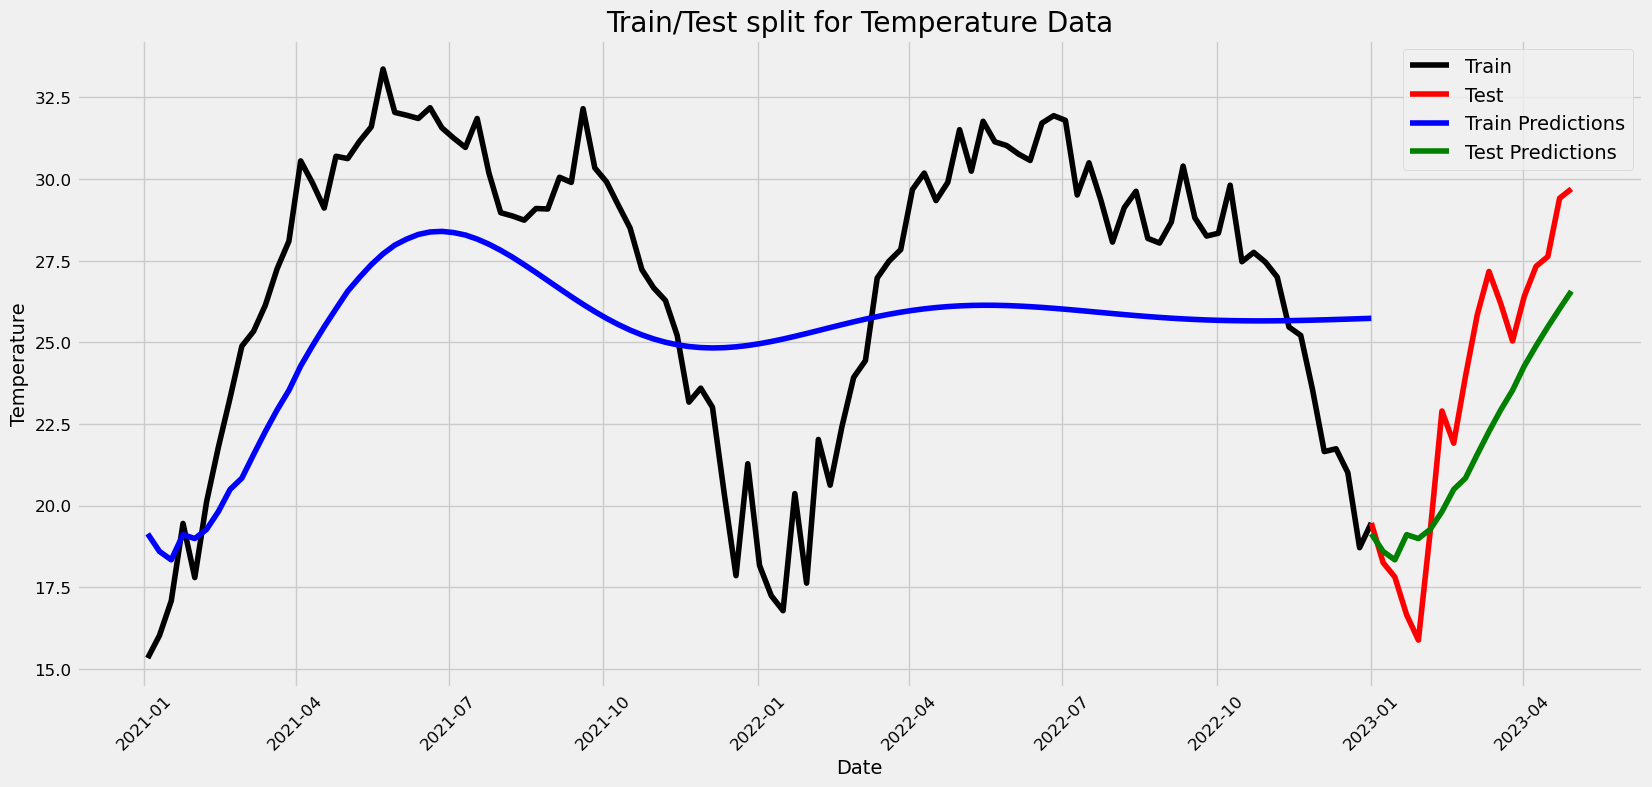

RMSE:  2.676078588164248


In [20]:
ARIMAmodel = ARIMA(train, order = (5,0,0))
ARIMAmodel = ARIMAmodel.fit()

#Train set prediction
y_pred_train = ARIMAmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = ARIMAmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

#Train set prediction
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [21]:
print(ARIMAmodel.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  105
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -166.044
Date:                Mon, 11 Nov 2024   AIC                            346.088
Time:                        19:49:59   BIC                            364.666
Sample:                    01-03-2021   HQIC                           353.616
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7878      1.556     16.577      0.000      22.739      28.837
ar.L1          0.6755      0.087      7.779      0.000       0.505       0.846
ar.L2          0.4121      0.105      3.928      0.0

# SARIMA

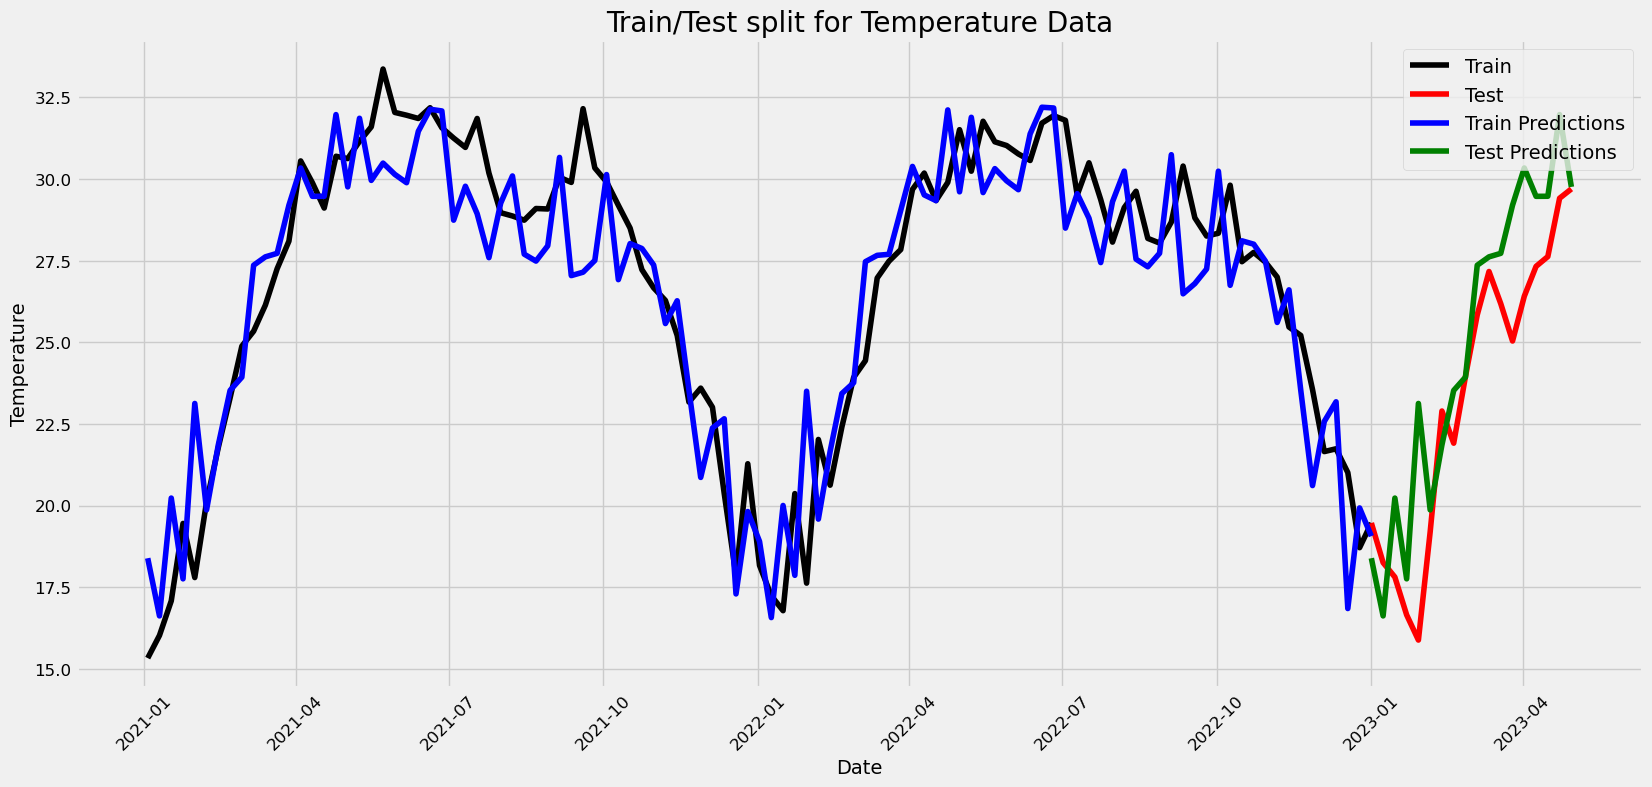

RMSE:  2.578793069736221


In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAXmodel = SARIMAX(train, order=(5,0,0),seasonal_order=(1, 1, 1, 52)) 
SARIMAXmodel = SARIMAXmodel.fit()

#Train set prediction
y_pred_train = SARIMAXmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

#Test set prediction
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [31]:
print(SARIMAXmodel.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 temp   No. Observations:                  105
Model:             SARIMAX(5, 0, 0)x(1, 1, [1], 52)   Log Likelihood                 -86.029
Date:                              Mon, 11 Nov 2024   AIC                            188.057
Time:                                      19:50:07   BIC                            203.819
Sample:                                  01-03-2021   HQIC                           194.118
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0636      0.152      0.419      0.675      -0.234       0.361
ar.L2          0.06

In [180]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [182]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:984.8420684895565
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:494.7744164276214
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:172.65649630216632
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:178.74279486497466
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:172.43484834312684
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:-15.886544222160214
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:849.108241492213
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:422.943606266862
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:171.25382044879603
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:6.0


C:\Users\ryash\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:180.9159513281407


C:\Users\ryash\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:171.16393722341587
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:-15.689365972531586
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:367.5640576142285
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:187.73308248038788
ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:201.25807703568472
ARIMA(0, 1, 0)x(0, 1, 1, 52)52 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 52)52 - AIC:186.44818366176327
ARIMA(0, 1, 0)x(1, 0, 1, 52)52 - AIC:185.27741532245003
ARIMA(0, 1, 0)x(1, 1, 0, 52)52 - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 0, 52)52 - AIC:364.4728302874333
ARIMA(0, 1, 1)x(0, 0, 1, 52)52 - AIC:184.1546537511613
ARIMA(0, 1, 1)x(0, 1, 0, 52)52 - AIC:171.12729749620988
ARIMA(0, 1, 1)x(0, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 1, 1)x(1, 0, 0, 52)52 - AIC:167.74066799617617
ARIMA(0, 1, 1)x(1, 0, 1, 52)52 - AIC:162.1349233558868
ARIMA(0, 1, 1)x(1, 1, 0, 52)52 - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 1, 52)52 - AIC:8.0
ARIMA(1, 0, 0)x(0, 0, 0, 52)52 - AIC:372.340

### Use optimal parameters from above with Lowest AIC

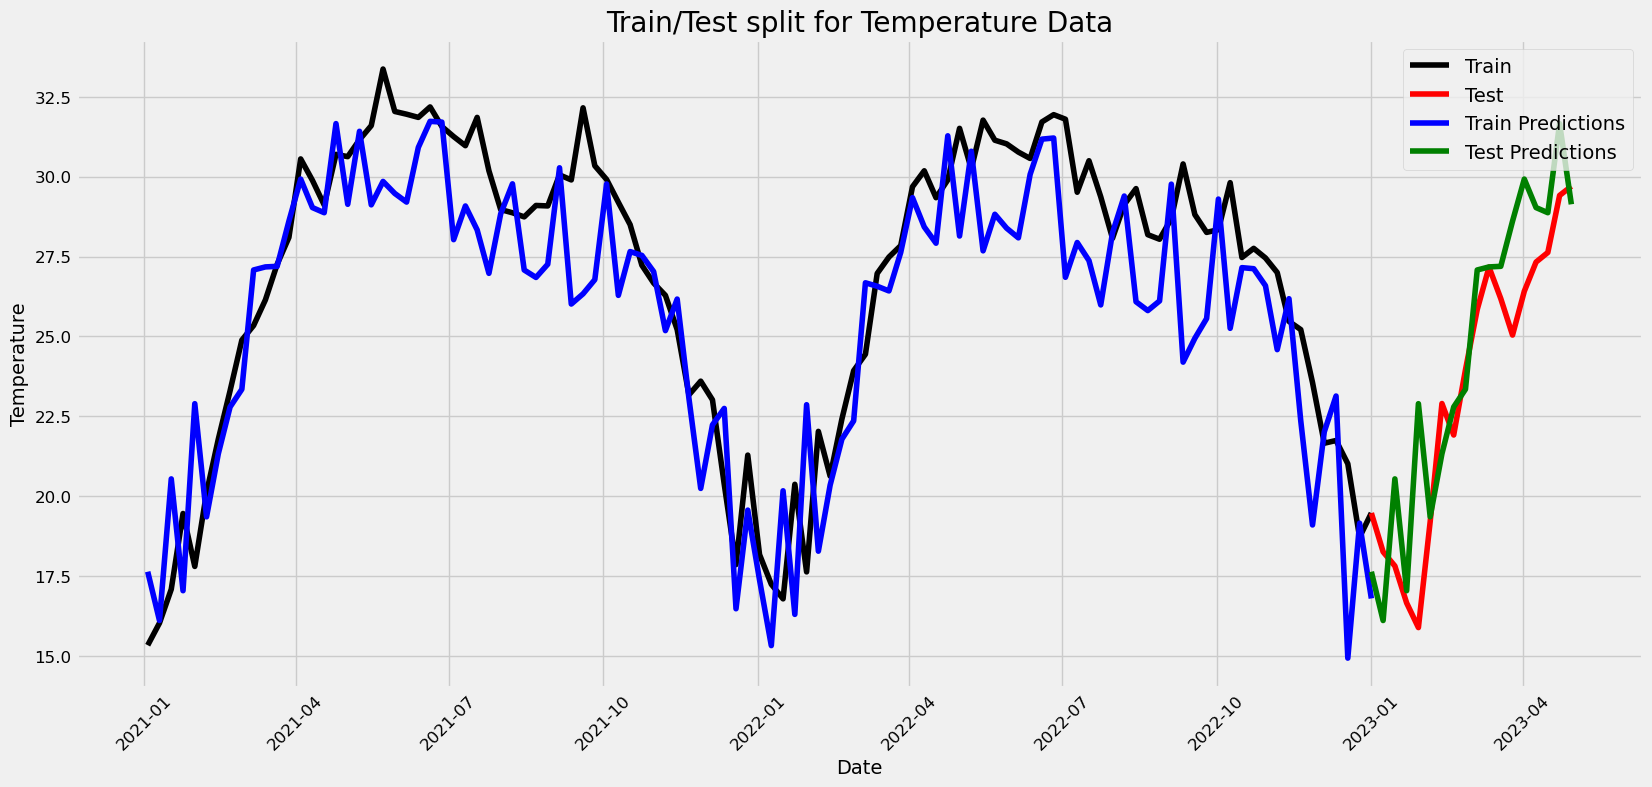

RMSE:  2.424172625200149


In [186]:
# Use optimal parameters from above with lowest AIC

SARIMAXmodel = SARIMAX(train, order=(1,1,1),seasonal_order=(1, 1, 1, 52)) 
SARIMAXmodel = SARIMAXmodel.fit()

#Train set prediction
y_pred_train = SARIMAXmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

#Test set prediction
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

#### Comparison:

Comparing both ARIMA and SARIMA, we can see that ARIMA has RMSE: 2.676 while SARIMA has RMSE: 2.424 (with optimal parameters using grid search). When comparing the performance of the ARIMA and SARIMA models on the dataset, the SARIMA model clearly outperforms the ARIMA model. This is evident from the significantly lower RMSE of the SARIMA model, indicating more accurate predictions. The graphical representation supports this, showing that the SARIMA model’s predictions (represented by the green line) closely follow the actual test data (the red line), unlike the ARIMA model. Consequently, the SARIMA model is better suited for this temperature data and provides more precise temperature forecasts.

## Using Machine Learning Model

In [64]:
train

datetime
2021-01-03    15.333333
2021-01-10    16.028571
2021-01-17    17.085714
2021-01-24    19.457143
2021-01-31    17.800000
                ...    
2022-12-04    21.657143
2022-12-11    21.742857
2022-12-18    21.014286
2022-12-25    18.714286
2023-01-01    19.471429
Freq: W-SUN, Name: temp, Length: 105, dtype: float64

In [109]:
import numpy as np
 
#extract the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]
 
#convert into one matrix
X = np.array([day, months, years]).T
Y = train.values

In [111]:
X[:10]

array([[   3,    1, 2021],
       [  10,    1, 2021],
       [  17,    1, 2021],
       [  24,    1, 2021],
       [  31,    1, 2021],
       [   7,    2, 2021],
       [  14,    2, 2021],
       [  21,    2, 2021],
       [  28,    2, 2021],
       [   7,    3, 2021]])

In [113]:
Y[:10]

array([15.33333333, 16.02857143, 17.08571429, 19.45714286, 17.8       ,
       20.11428571, 21.78571429, 23.3       , 24.88571429, 25.34285714])

In [115]:
# extract the day, month and year data
tmonths = [x.month for x in test.index]
tyears = [x.year for x in test.index]
tday = [x.day for x in test.index]
 
# convert into one matrix
testX = np.array([tday, tmonths, tyears]).T
testY = test.values

In [117]:
testX

array([[   1,    1, 2023],
       [   8,    1, 2023],
       [  15,    1, 2023],
       [  22,    1, 2023],
       [  29,    1, 2023],
       [   5,    2, 2023],
       [  12,    2, 2023],
       [  19,    2, 2023],
       [  26,    2, 2023],
       [   5,    3, 2023],
       [  12,    3, 2023],
       [  19,    3, 2023],
       [  26,    3, 2023],
       [   2,    4, 2023],
       [   9,    4, 2023],
       [  16,    4, 2023],
       [  23,    4, 2023],
       [  30,    4, 2023]])

In [119]:
testY[:10]

array([19.47142857, 18.25714286, 17.81428571, 16.65714286, 15.88571429,
       19.2       , 22.9       , 21.91428571, 23.95714286, 25.84285714])

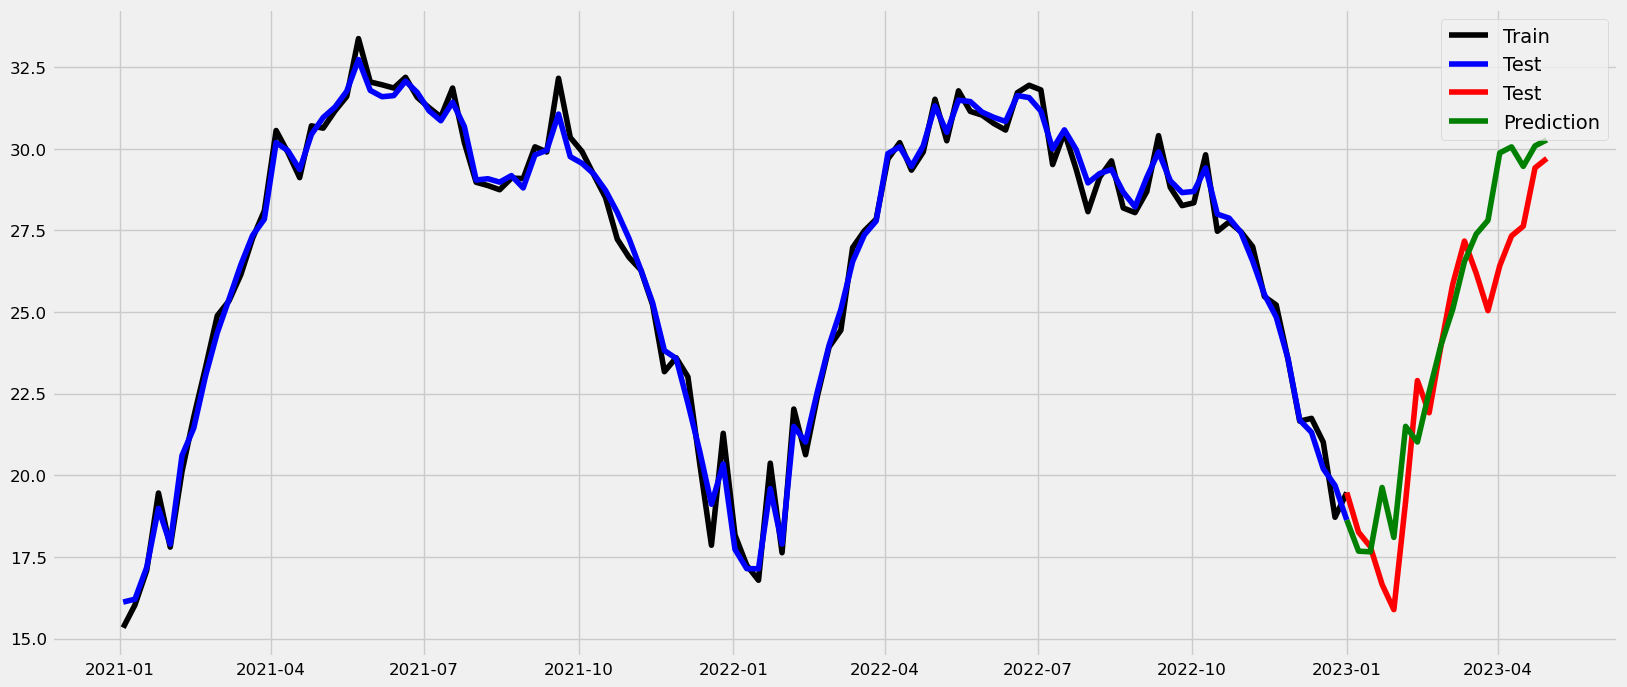

RMSE:  1.7887187598499892


In [125]:
from sklearn.ensemble import RandomForestRegressor
 
# fit the model
rfmodel = RandomForestRegressor()
rfmodel.fit(X,Y)

# predict for the test set period
preds_train = rfmodel.predict(X)

# predict for the test set period
preds = rfmodel.predict(testX)
 
# plot what has been learned
plt.plot(train.index.values, train.values,color="black", label='Train')
plt.plot(train.index.values, preds_train,color="blue", label='Test')
plt.plot(test.index.values, test.values,color="red", label='Test')
plt.plot(test.index.values, preds, color="green",label='Prediction')
plt.legend()
plt.show()
rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ",rf_rmse)

#### Comparison:

In this scenario, the Random Forest regression model achieves the lowest RMSE value at 1.788, outperforming both SARIMA and ARIMA models. The SARIMA model registers an RMSE of 2.424, while ARIMA records the highest RMSE at 2.676, indicating the least accurate predictions among these models.

Considering the RMSE values for ARIMA, SARIMA, and Random Forest regression algorithms, it can be inferred that the Random Forest regressor performs the best among the techniques employed, with the lowest RMSE compared to the other two models. Additionally, visualized results demonstrate a strong alignment between predicted and test values across the entire dataset, making Random Forest a suitable fit for the weather dataset. Although SARIMA shows reasonable accuracy with a lower RMSE than ARIMA, the latter model performs the poorest, with a significantly higher RMSE and substantial deviations between predicted and test values.

Therefore, based on RMSE values, the Random Forest model emerges as the superior choice for this dataset, while the ARIMA model is the least effective. However, other factors like computational complexity and interpretability should also be considered when selecting the most suitable model for a specific use case.

## Forcasting future values

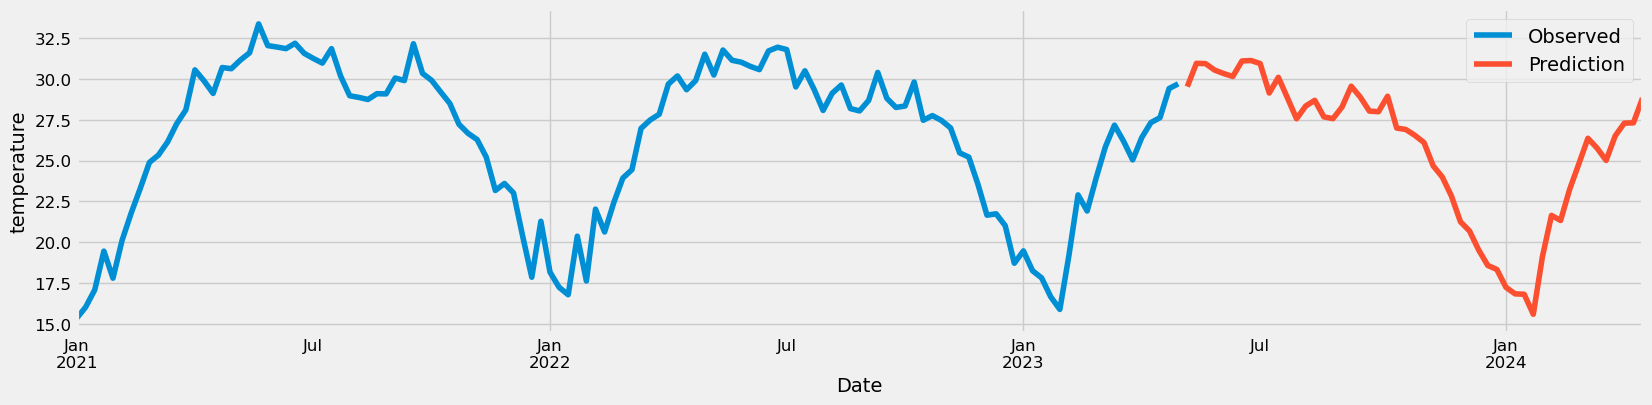

In [193]:
start_date = '01/11/2024'
end_date = '31/12/2024'
future_dates = pd.date_range(start=start_date, end=end_date, freq='W')

train = weekly_df[weekly_df.index <= pd.to_datetime("2024-11-01", format='%Y-%m-%d')]

#Defining the SARIMA model with optimal parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52) # 52 weeks in a year
SARIMAXmodel = SARIMAX(train, order=order, seasonal_order=seasonal_order)

#Fitting the model to the training data
SARIMAXfit = SARIMAXmodel.fit()

#Generating predictions for the future dates
pred_u = SARIMAXfit.get_forecast(steps=len(future_dates))
pred_c = pred_u.conf_int()

#Plotting the observed data and the forecast
ax = train.plot(label='Observed', figsize=(18, 4))
pred_u.predicted_mean.plot(ax=ax, label='Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('temperature')
plt.legend()
plt.show()

This graph illustrates the correlation between date and temperature for both observed and forecasted data. The red line in the graph represents the forecasted data, displaying a strikingly similar pattern to the blue line, which represents the observed data. This graph serves as the basis for the forecasted data.

In [196]:
pred_mean = pred_u.predicted_mean
forecast_da = pd.DataFrame({'date': future_dates, 'temp_Pre': pred_mean.values,})

#Setting the index to the date column
forecast_da.set_index('date', inplace=True)
Res = forecast_da[forecast_da.index >= pd.to_datetime("2024-11-01", format='%Y-%m-%d')]
Res

,temp_Pre
date,
2024-11-03,23.249535
2024-11-10,24.795095
2024-11-17,26.366602
2024-11-24,25.769462
2024-12-01,25.011664
2024-12-08,26.518308
2024-12-15,27.294343
2024-12-22,27.314543
2024-12-29,28.828743


In [198]:
# Extracting the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]

# Converting into one matrix
trainX2 = np.array([day, months, years]).T
trainY2 = train.values

# Extract the day, month and year data
tmonths = [x.month for x in test.index]
tyears = [x.year for x in test.index]
tday = [x.day for x in test.index]

# Convert into one matrix
testX2 = np.array([tday, tmonths, tyears]).T
testY2 = test.values

In [200]:
#Random Forest Regression Model

rfmodel = RandomForestRegressor()
rfmodel.fit(trainX2,trainY2)

pred = rfmodel.predict(testX2)
pred = pd.Series(pred)
pred

0     18.783619
1     17.834429
2     17.467571
3     17.491286
4     16.637143
5     20.200857
6     22.145286
7     22.242429
8     23.943857
9     25.607429
10    26.799143
11    26.344286
12    26.099000
13    27.119857
14    27.631714
15    27.811714
16    28.956571
17    29.389429
dtype: float64

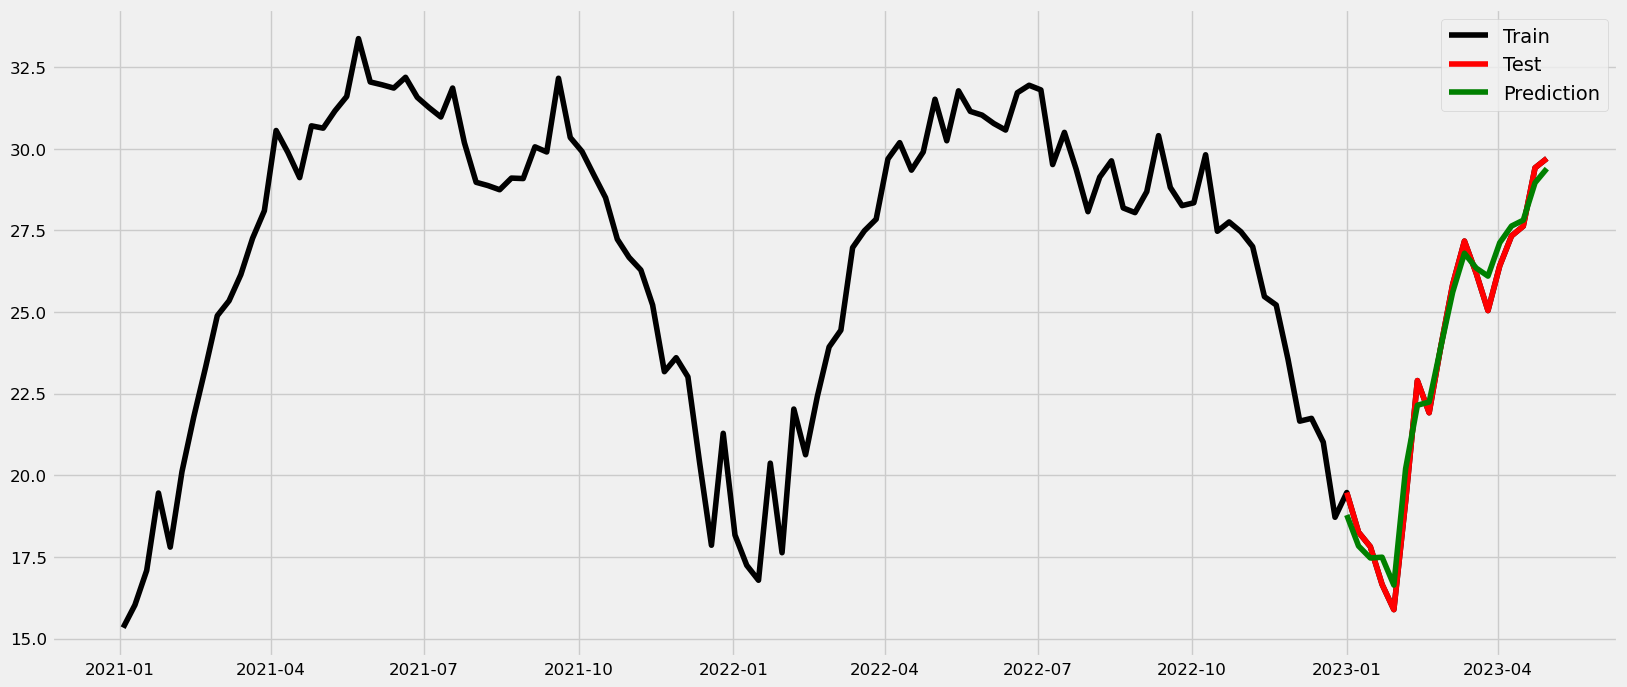

RMSE:  1.7887187598499892


In [202]:
plt.plot(train.index, train.values,color="black", label='Train')
plt.plot(test.index, test.values,color="red", label='Test')
plt.plot(test.index, pred, color="green",label='Prediction')
plt.legend()
plt.show()

rf_rmse = np.sqrt(mean_squared_error(test.values, preds))
print("RMSE: ",rf_rmse)

The root mean square error (RMSE) of 1.788 indicates a difference of about 1.78 units between predicted and forecasted values. This difference is slightly lower than the RMSE observed when using the Random Forest Regressor on the previous test dataset from the original dataset. Therefore, it can be deduced that although the Random Forest Regressor performed well on the original dataset, its effectiveness may be slightly enhanced when applied to the forecasted dataset.